# **Step2. Multi-label 분류**



**미션 : 리뷰에 포함된 11가지 속성을 검출하기(Multi-label Multi-Classification)**

1) 목표 : 리뷰 내용에서, 속성에 해당하는 내용이 등장하는지 분류하는
모델 생성
2) 절차
    * 데이터 전처리 : 주어진 데이터를 목표에 맞는 형태로 변환
    * 모델링 : 다중 레이블 분류 파인 튜닝
        * 일반 파인 튜닝
        * LoRA 파인 튜닝

## 1.환경준비

### (1) 라이브러리 설치 및 로딩

In [ ]:
!pip install datasets #peft accelerate -q

In [ ]:
# 한글폰트 설치
import matplotlib as mpl
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import torch

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

from peft import get_peft_model, LoraConfig, TaskType

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

### (2) GPU 설정
* GPU 사용을 위한 설정

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.데이터 준비

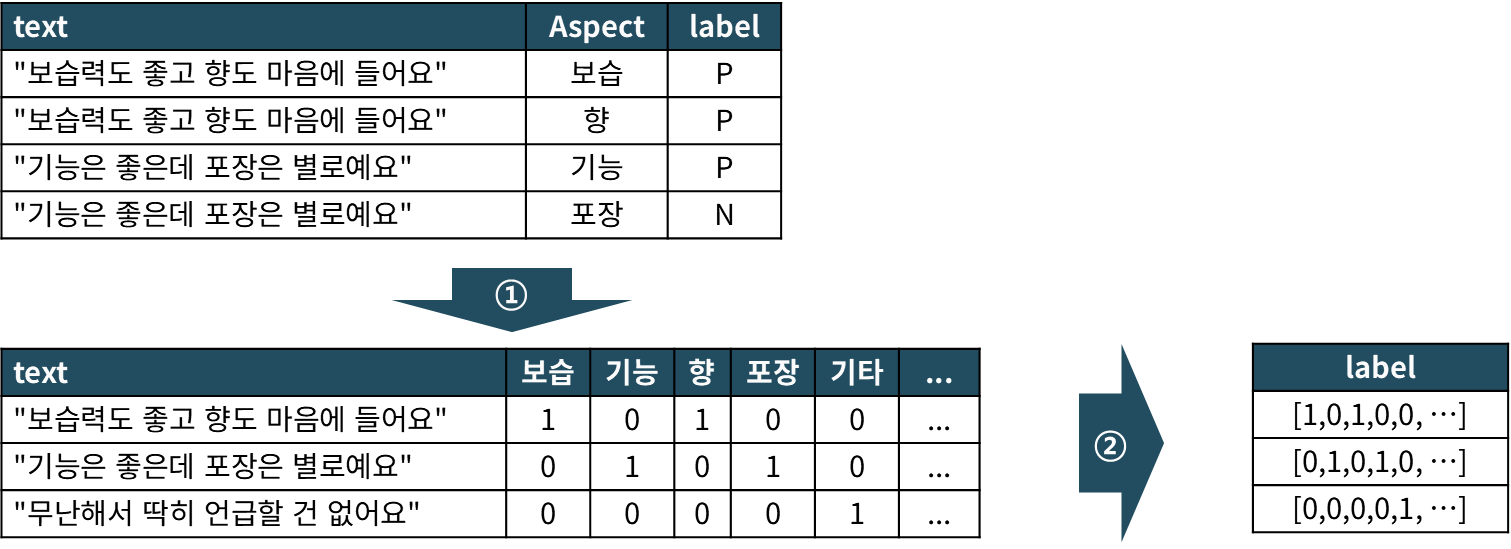

### (1) 데이터 로딩
* data.csv 파일 로딩

In [ ]:
# 파일 업로드
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
data = pd.read_csv('data.csv')
data.head()

,text,aspect,label
0,유통기한도 넉넉하고 구성도 많아서 선물 하기 좋네요. 만족합니다.,포장,1
1,유통기한도 넉넉하고 구성도 많아서 선물 하기 좋네요. 만족합니다.,품질,1
2,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,보습,1
3,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,포장,0
4,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,기타,1


### (2) Dataset 준비1

In [ ]:
# 레이블 리스트
labels = ['보습', '기능', '밀착', '가격', '향', '편의성', '기타', '외형', '포장', '품질', '피부']

* multi-hot label 만들기
    * multi-hot label 값이 문자열이 아닌 리스트여야 합니다.
* multi-hot label을 추가한 데이터셋을 data1 으로 저장합니다.

In [ ]:
# 멀티핫 인코딩 벡터 생성
def create_multihot_vector(aspect_list, labels):
    return [1 if aspect in aspect_list else 0 for aspect in labels]

df_aspect_presence = data.groupby(['text', 'aspect']).size().reset_index(name='count')
data1 = df_aspect_presence.groupby('text')['aspect'].apply(list).reset_index()
data1['label'] = data1['aspect'].apply(lambda x: create_multihot_vector(x, labels))
data1.head()

,text,aspect,label
0,'2021 OO 명예의 전당'에 오른 OOO OOOO 토너 사용후기예요. 성분 좋기...,"[기타, 밀착, 보습, 포장, 품질, 피부]","[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]"
1,'2022 대한민국소비자대상' 수상을 축하하며 오랜만에 써 본 OO OOO 로션 사...,"[보습, 편의성, 피부]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]"
2,'OO OOO 쿠션 파운데이션' 이 제품 이름을 보고 너무 궁금해서 구입했어요. 얼...,"[밀착, 보습, 외형, 포장]","[1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]"
3,(장점 ) 1.쓰기편하고 제형이 묽어서 발림성 좋다. 2.백탁없다 (단점) 1.교체...,"[기타, 밀착, 편의성, 품질, 향]","[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]"
4,* 향기도 너무 마음에 들고 발라보니 촉촉하고 부드럽고 매끄러워 피부가 좋아지는 것...,"[보습, 향]","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


* 검증 : 제대로 생성되었는지 다음 코드로 검증해 봅니다.

In [ ]:
labels

['보습', '기능', '밀착', '가격', '향', '편의성', '기타', '외형', '포장', '품질', '피부']

In [ ]:
review = "(장점 ) 1.쓰기편하고 제형이 묽어서 발림성 좋다. 2.백탁없다 (단점)"
display(data[data['text'].str.startswith(review)])
display(data1[data1['text'].str.startswith(review)])

,text,aspect,label
42656,(장점 ) 1.쓰기편하고 제형이 묽어서 발림성 좋다. 2.백탁없다 (단점) 1.교체...,밀착,1
42657,(장점 ) 1.쓰기편하고 제형이 묽어서 발림성 좋다. 2.백탁없다 (단점) 1.교체...,품질,0
42658,(장점 ) 1.쓰기편하고 제형이 묽어서 발림성 좋다. 2.백탁없다 (단점) 1.교체...,기타,1
42659,(장점 ) 1.쓰기편하고 제형이 묽어서 발림성 좋다. 2.백탁없다 (단점) 1.교체...,편의성,1
42660,(장점 ) 1.쓰기편하고 제형이 묽어서 발림성 좋다. 2.백탁없다 (단점) 1.교체...,향,1


,text,aspect,label
3,(장점 ) 1.쓰기편하고 제형이 묽어서 발림성 좋다. 2.백탁없다 (단점) 1.교체...,"[기타, 밀착, 편의성, 품질, 향]","[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]"


* 전체 데이터에서 10000건을 샘플링 합니다.(파인튜닝 시간 절약을 위해서)

In [ ]:
# sampling
data2 = data1.sample(10000, random_state = 100)
data2.reset_index(drop=True, inplace=True)

### (3) Dataset 준비2
* train, val 분할 7:3
* 텐서 데이터셋

In [ ]:
# train, val 분할 7:3
train, val = train_test_split(data2, test_size=0.3, random_state=100)

In [ ]:
# df로 부터 텐서 데이터셋 만들기
train_ts = Dataset.from_pandas(train)
val_ts = Dataset.from_pandas(val)

In [ ]:
train_ts[:3]

{'text': ['깔끔하게 잘 발립니다.하지만 풍성하거나 그런건 아니에요',
  '저녁에 짱구눈썹으로 칠하고 자도 아침에 진하게 물들지 않아요.. 자연스러운 걸 좋아하는 분들은 괜찮지만 저처럼 귀찮은게 싫어서 일주일 지속 되길 원하는 분들에겐 비추입니다..',
  '오후에 주문 했는데 다음날 바로 받았어요. 피부가 끈적이지 않고 가성비는 좋아요. 촉촉함은 부족한 듯합니다. 건성피부에는 촉촉함이 아쉽네요.'],
 'aspect': [['기능', '밀착'], ['기타', '외형'], ['가격', '밀착', '보습', '피부']],
 'label': [[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]],
 '__index_level_0__': [1191, 4458, 1131]}

### (4) 토크나이징

* 다중 레이블 분류 문제에서 label은 float 타입이어야 함

In [ ]:
# 토크나이저 다운로드
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# 전처리 함수 정의 : label을 float 타입으로 변환 포함
def preprocess_function(data):
    tokenized = tokenizer(data['text'], truncation=True, padding='max_length', max_length=128)
    tokenized['labels'] = [list(map(float, labels)) for labels in data['label']]
    return tokenized

# 전처리 적용
train_ts = train_ts.map(preprocess_function, batched=True)
val_ts = val_ts.map(preprocess_function, batched=True)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

## 3.Fine-Tuning1
* 일반 파인 튜닝으로

### (1) 사전학습 모델 준비
* problem_type="multi_label_classification"

In [ ]:
# label(클래스) 수 지정
num_labels = 11

# 모델 준비 : 옵션 problem_type="multi_label_classification" 추가
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) 학습 설정

* TrainArguments

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,               # 작은 학습률
    per_device_train_batch_size = 32,   # 학습 배치 사이즈
    per_device_eval_batch_size = 32,
    num_train_epochs = 5,               # 에폭 수
    weight_decay = 0.02,                # weight decay
    load_best_model_at_end = True,      # earlystopping 사용하기 위해 필요
    logging_dir ='./logs',
    logging_steps = 10,
    report_to="tensorboard"
)

* Trainer

In [ ]:
# 학습 시 추가 함수 준비
from torch.utils.data import DataLoader
from transformers import default_data_collator

# 평가함수(선택 사항)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs > 0.5).astype(int)
    return {
        "weighted_f1": f1_score(labels, preds, average="weighted"),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

# 사용자 정의 data_collator(필수 사항)
def float_label_collator(features):
    batch = default_data_collator(features)
    batch["labels"] = batch["labels"].float()
    return batch

In [ ]:
# Trainer 설정
trainer = Trainer(
    model=model,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ts,
    eval_dataset = val_ts,
    tokenizer = tokenizer,
    data_collator=float_label_collator,  # 오류 자주 발생.
    compute_metrics=compute_metrics,     # 추가 측정 지표
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], # 조기 종료
)

/tmp/ipython-input-1122503084.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### (3) 학습
* 7000건 학습데이터에 대해서, 학습 시간이 10~13분 정도 소요 됩니다.

In [ ]:
# 모델 학습
trainer.train()

Epoch,Training Loss,Validation Loss,Weighted F1,Macro F1
1,0.294100,0.271046,0.789319,0.779361
2,0.210000,0.202493,0.860949,0.859022
3,0.180200,0.178622,0.876485,0.875540
4,0.156700,0.167287,0.890059,0.887825
5,0.133400,0.162978,0.891023,0.888868


TrainOutput(global_step=1095, training_loss=0.22269455406763783, metrics={'train_runtime': 886.3188, 'train_samples_per_second': 39.489, 'train_steps_per_second': 1.235, 'total_flos': 2302407770880000.0, 'train_loss': 0.22269455406763783, 'epoch': 5.0})

### (4) 모델 검증평가

In [ ]:
# 예측
raw_pred = trainer.predict(val_ts)

In [ ]:
raw_pred

PredictionOutput(predictions=array([[-1.9552884 , -1.5160263 ,  2.6375537 , ..., -3.3654451 ,
        -2.565361  , -3.1556928 ],
       [-2.9018042 , -1.8259724 , -3.2538228 , ..., -2.6723378 ,
        -3.3691914 , -3.0690174 ],
       [ 3.109895  ,  3.4400625 , -3.4039328 , ..., -3.1735694 ,
        -3.2688632 , -0.92657   ],
       ...,
       [-1.1269116 ,  0.04673547,  3.0713413 , ..., -2.063302  ,
        -1.7368292 , -2.814597  ],
       [-1.793275  ,  0.25863874,  0.48530442, ..., -1.7434647 ,
         4.3140697 ,  1.3373753 ],
       [ 2.7853746 , -3.2740352 , -3.1101785 , ...,  2.2073019 ,
        -3.0370455 , -3.469039  ]], dtype=float32), label_ids=array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 0.]], dtype=float32), metrics={'test_loss': 0.1629783660173416, 'test_weighted_f1': 0.89102327780

* 예측값

In [ ]:
logits = raw_pred.predictions

In [ ]:
probs = 1 / (1 + np.exp(-logits))
probs

array([[0.12397786, 0.18004742, 0.9332397 , ..., 0.03339302, 0.07140128,
        0.04086755],
       [0.05206445, 0.13871877, 0.03718976, ..., 0.06462551, 0.03327231,
        0.0444035 ],
       [0.9572991 , 0.9689334 , 0.03217278, ..., 0.04017255, 0.03665495,
        0.2836211 ],
       ...,
       [0.2447315 , 0.51168174, 0.955695  , ..., 0.11271518, 0.14971615,
        0.05654046],
       [0.14267167, 0.56430167, 0.61899966, ..., 0.14887339, 0.98679763,
        0.79205793],
       [0.9418804 , 0.03647276, 0.04268935, ..., 0.9009033 , 0.04578007,
        0.03020612]], dtype=float32)

In [ ]:
preds = np.where(probs > 0.5, 1, 0)

* 실제값

In [ ]:
true = raw_pred.label_ids             # 정답 레이블

* 평가

In [ ]:
# average=None : 각 레이블 별로 분리해서 평가
precisions, recalls, f1s, supports = precision_recall_fscore_support(
    true, preds, average=None, zero_division=0)

# 출력
for i, label in enumerate(labels):
    print(f"{label:5} | Precision: {precisions[i]:.3f}, Recall: {recalls[i]:.3f}, F1: {f1s[i]:.3f}, Support: {supports[i]}")

보습    | Precision: 0.899, Recall: 0.929, F1: 0.914, Support: 1074
기능    | Precision: 0.860, Recall: 0.791, F1: 0.824, Support: 1077
밀착    | Precision: 0.914, Recall: 0.917, F1: 0.916, Support: 905
가격    | Precision: 0.971, Recall: 0.967, F1: 0.969, Support: 828
향     | Precision: 0.924, Recall: 0.965, F1: 0.944, Support: 817
편의성   | Precision: 0.864, Recall: 0.782, F1: 0.821, Support: 657
기타    | Precision: 0.887, Recall: 0.816, F1: 0.850, Support: 664
외형    | Precision: 0.871, Recall: 0.895, F1: 0.883, Support: 572
포장    | Precision: 0.935, Recall: 0.908, F1: 0.921, Support: 574
품질    | Precision: 0.899, Recall: 0.827, F1: 0.862, Support: 504
피부    | Precision: 0.890, Recall: 0.859, F1: 0.874, Support: 425


In [ ]:
df = pd.DataFrame({
    "label": labels,
    "precision": precisions,
    "recall": recalls,
    "f1": f1s,
    "support": supports
})
df_melted = df.melt(id_vars='label', value_vars=['precision', 'recall', 'f1'],
                    var_name='metric', value_name='score')

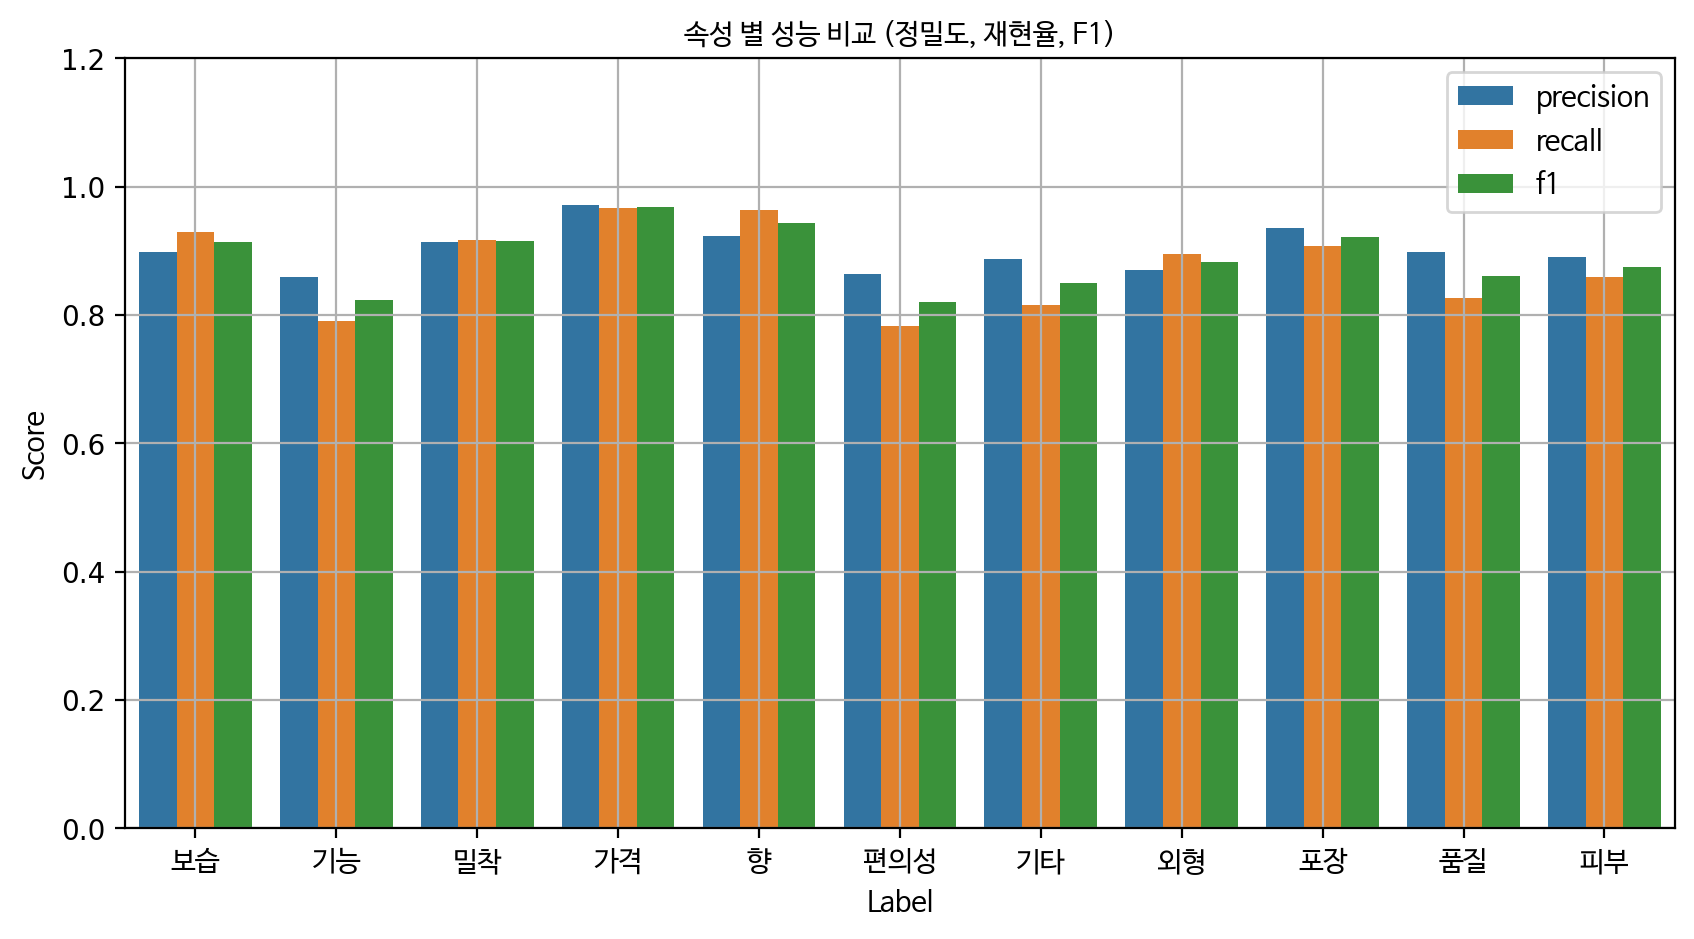

In [ ]:
# barplot 그리기
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x='label', y='score', hue='metric')

# 3. 한글 폰트 설정 (필요 시)
plt.xticks(fontproperties=fontprop)
plt.title("속성 별 성능 비교 (정밀도, 재현율, F1)", fontproperties=fontprop)
plt.ylabel("Score", fontproperties=fontprop)
plt.xlabel("Label", fontproperties=fontprop)
plt.ylim(0, 1.2)
plt.legend(prop=fontprop)
plt.grid()
plt.show()

## 4.Fine-Tuning2
* LoRA 튜닝하기

### (1) 사전학습 모델 준비
* problem_type="multi_label_classification"

In [ ]:
num_labels = 11

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) LoRA 구성

In [ ]:
# LoRA 구성 정의
lora_config = LoraConfig(
    r=8,                         # 랭크
    lora_alpha=32,              # scaling factor
    target_modules=["query", "value"],  # LoRA 적용 대상
    lora_dropout=0.05,
    bias="none",                # bias 조정 없음
    task_type=TaskType.SEQ_CLS # 시퀀스 분류 태스크
)

# LoRA 적용
model2 = get_peft_model(model, lora_config)

### (3) 학습 설정

* TrainArguments
    * 일반 파인 튜닝보다는 학습률을 조금 높게 설정

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-4,               # 작은 학습률
    per_device_train_batch_size = 32,   # 학습 배치 사이즈
    per_device_eval_batch_size = 32,
    num_train_epochs = 5,               # 에폭 수
    weight_decay = 0.02,                # weight decay
    load_best_model_at_end = True,      # earlystopping 사용하기 위해 필요
    logging_dir ='./logs',
    logging_steps = 10,
    report_to="tensorboard"
)

* Trainer

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

def float_label_collator(features):
    batch = default_data_collator(features)
    batch["labels"] = batch["labels"].float()
    return batch

# Trainer 설정
trainer = Trainer(
    model=model2,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ts,
    eval_dataset = val_ts,
    tokenizer = tokenizer,
    data_collator = float_label_collator,  # 오류 자주 발생.
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], # 조기 종료
)

/tmp/ipython-input-3050749919.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### (4) 학습

In [ ]:
# 모델 학습
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.368000,0.348158
2,0.298000,0.280410
3,0.264100,0.247233
4,0.246700,0.230976
5,0.234100,0.225705


TrainOutput(global_step=1095, training_loss=0.30879396020549615, metrics={'train_runtime': 629.5117, 'train_samples_per_second': 55.599, 'train_steps_per_second': 1.739, 'total_flos': 2310562383360000.0, 'train_loss': 0.30879396020549615, 'epoch': 5.0})

In [ ]:
# 모델 평가
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.22570466995239258, 'eval_runtime': 21.4574, 'eval_samples_per_second': 139.812, 'eval_steps_per_second': 4.381, 'epoch': 5.0}


### (5) 모델 검증평가

In [ ]:
# 예측
raw_pred = trainer.predict(val_ts)
logits = raw_pred.predictions
probs = 1 / (1 + np.exp(-logits))     # sigmoid 적용
preds = (probs > 0.5).astype(int)     # 0.5 기준 이진화
true = raw_pred.label_ids             # 정답 레이블

In [ ]:
# average=None: 각 레이블별로 분리해서 평가
precisions, recalls, f1s, supports = precision_recall_fscore_support(
    true, preds, average = None, zero_division=0
)

# 출력
for i, label in enumerate(labels):
    print(f"{label:5} | Precision: {precisions[i]:.3f}, Recall: {recalls[i]:.3f}, F1: {f1s[i]:.3f}, Support: {supports[i]}")

보습    | Precision: 0.854, Recall: 0.863, F1: 0.858, Support: 1074
기능    | Precision: 0.681, Recall: 0.520, F1: 0.590, Support: 1077
밀착    | Precision: 0.890, Recall: 0.864, F1: 0.877, Support: 905
가격    | Precision: 0.957, Recall: 0.965, F1: 0.961, Support: 828
향     | Precision: 0.916, Recall: 0.963, F1: 0.939, Support: 817
편의성   | Precision: 0.824, Recall: 0.726, F1: 0.772, Support: 657
기타    | Precision: 0.865, Recall: 0.646, F1: 0.740, Support: 664
외형    | Precision: 0.828, Recall: 0.781, F1: 0.804, Support: 572
포장    | Precision: 0.922, Recall: 0.885, F1: 0.903, Support: 574
품질    | Precision: 0.906, Recall: 0.653, F1: 0.759, Support: 504
피부    | Precision: 0.840, Recall: 0.421, F1: 0.561, Support: 425


In [ ]:
df = pd.DataFrame({
    "label": labels,
    "precision": precisions,
    "recall": recalls,
    "f1": f1s,
    "support": supports
})
df_melted = df.melt(id_vars='label', value_vars=['precision', 'recall', 'f1'],
                    var_name='metric', value_name='score')

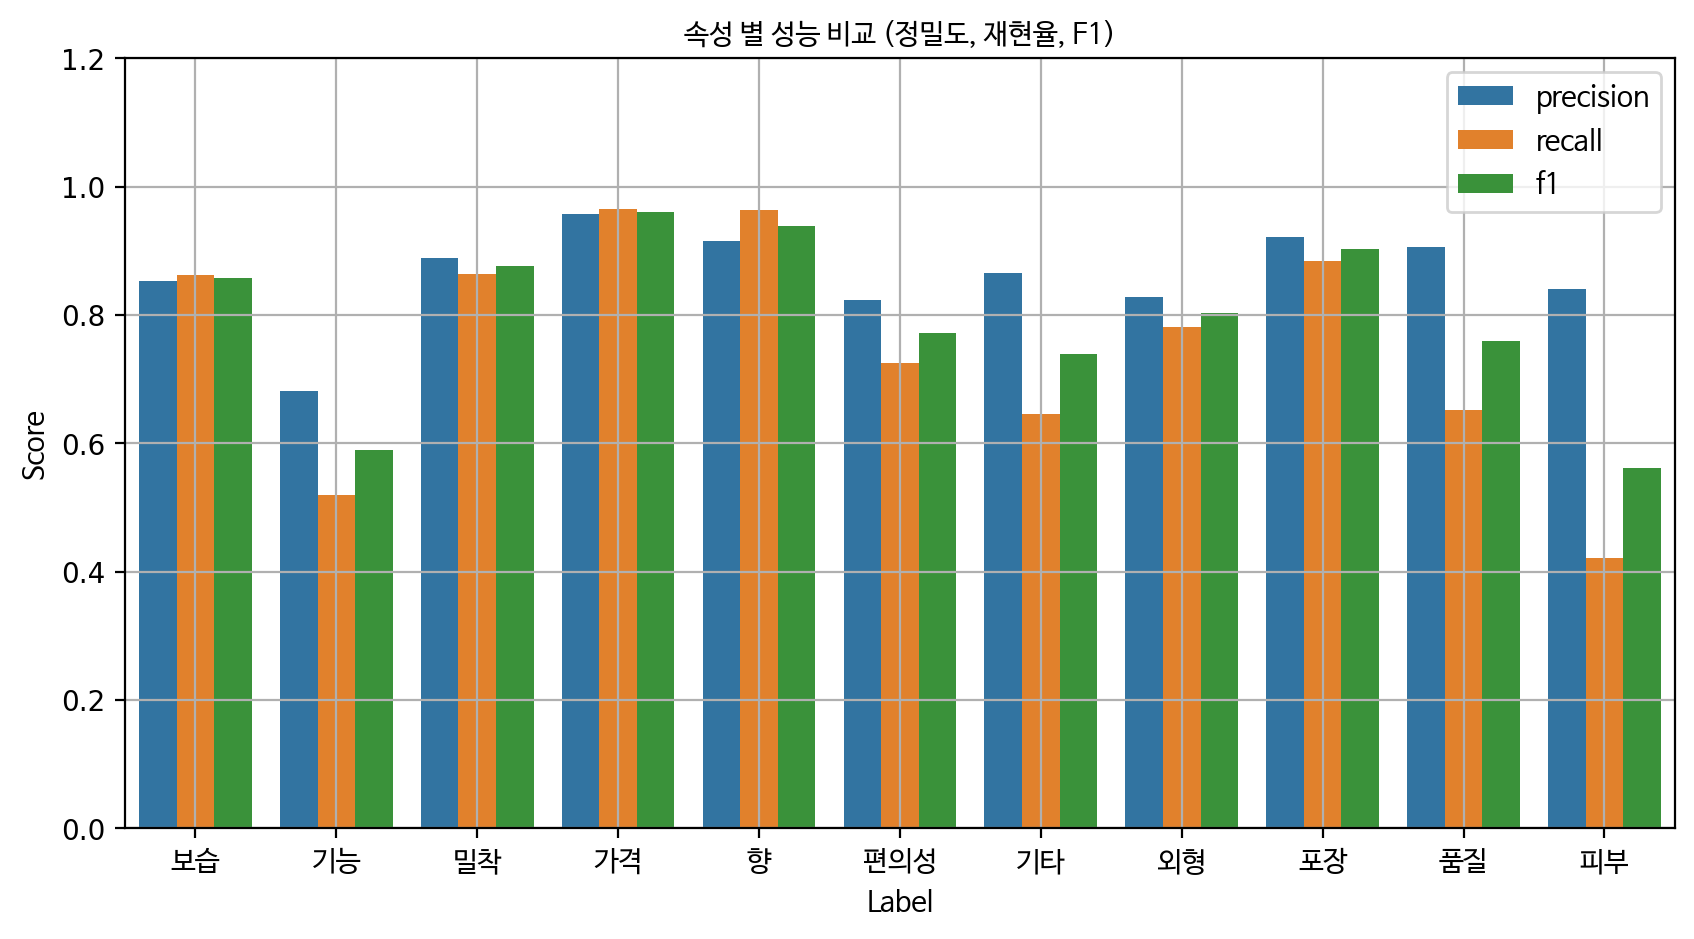

In [ ]:
# barplot 그리기
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x='label', y='score', hue='metric')

# 3. 한글 폰트 설정 (필요 시)
plt.xticks(fontproperties=fontprop)
plt.title("속성 별 성능 비교 (정밀도, 재현율, F1)", fontproperties=fontprop)
plt.ylabel("Score", fontproperties=fontprop)
plt.xlabel("Label", fontproperties=fontprop)
plt.ylim(0, 1.2)
plt.legend(prop=fontprop)
plt.grid()
plt.show()